# **Introduction**

**Problem Statement**

The aim of this challenge is to Predict the number of sales for the first 15 days of 2019 for the Small Basket. As Small Basket is trying to manage its supply chain and delivery partners and would like to accurately forecast the sales for the period starting from 1st January 2019 to 15th January 2019

# Importing libraries

In [0]:
# import necessary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc

In [0]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Training** **Data**

In [0]:
# Reading training data set
data = pd.read_csv('/content/drive/My Drive/phd/train.csv', dtype={'date':'object',
                                                                                  'locationId':'category',
                                                                                  'item_id':'object',
                                                                                  'unit_sales':'float32',
                                                                                  'onpromotion':'object'})
#shape of a column
(data.shape)

(101688779, 5)


In [0]:
data.head(5)

,date,locationId,item_id,unit_sales,onpromotion
0,2015-01-01,location_25,item_103665,7.0,NaN
1,2015-01-01,location_25,item_105574,1.0,NaN
2,2015-01-01,location_25,item_105575,2.0,NaN
3,2015-01-01,location_25,item_108079,1.0,NaN
4,2015-01-01,location_25,item_108701,1.0,NaN


The training set has 101,688,779 rows and 6 columns: row id, date, locationID, item_id, unit_sales (keep in mind that this can be an integer, float, or -1, which represents a returned item),onpromotion

**train.csv**
* date: The sales measured during a particular day
* location_id: The location from where the sold units were dispatched
* item_id: The identifier of a product that was sold
* unit_sales: The number of sales of a particular item from a particular
  location at the given date
* onpromotion: Whether the given product was sold in a promotion or
  a discount

Text(0, 0.5, 'Observations')

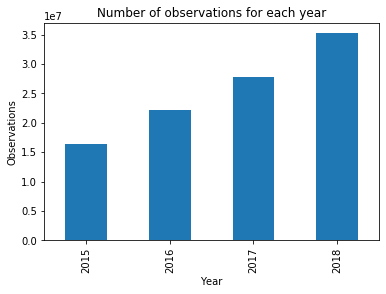

In [0]:
# convert date to datetime
data["date"] =  pd.to_datetime(data["date"])
#plot
data["date"].dt.year.value_counts(sort = False).plot.bar()
plt.title('Number of observations for each year')
plt.xlabel('Year')
plt.ylabel('Observations')

They have collected data from 2015 to 2018. There is an increase in the number of observations for each year . Note that the training dataset is quite large so I will focus my analysis hereafter on 2018 data.

In [0]:
# subsetting data for only year 2018
data_2018 = data[data["date"].dt.year == 2018]
del data; gc.collect() # free up some memory

129

Let's take a look at how the data is distributed by month.

Text(0, 0.5, 'Observations')

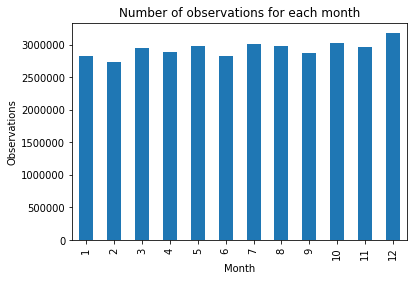

In [0]:
#bar plot
data_2018["date"].dt.month.value_counts(sort = False).plot.bar()
plt.title('Number of observations for each month')
plt.xlabel('Month')
plt.ylabel('Observations')

The observations are almost uniformly distributed by month. The maximum occurs in December and the minimum in February

# **location_details**

Now, let's determine how many locations there are and the distribution of observations for each store.

Text(0, 0.5, 'Observations')

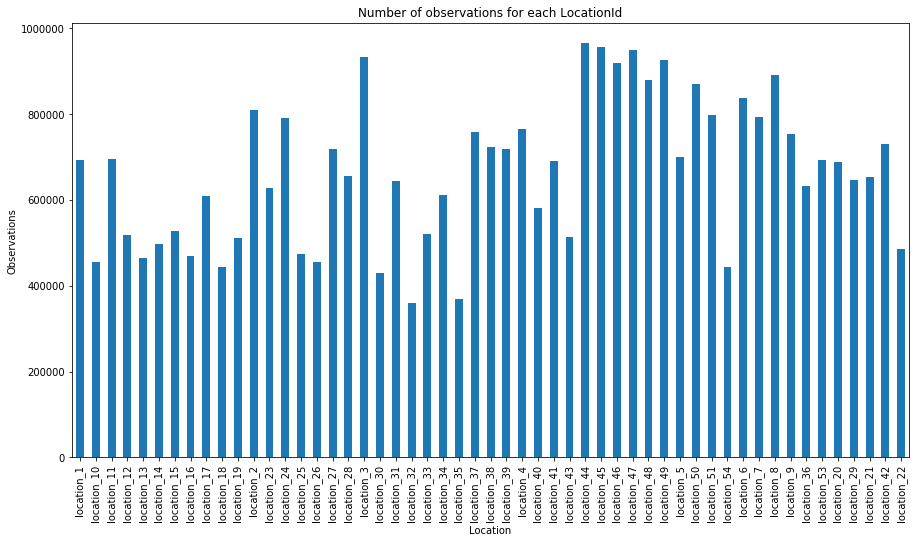

In [0]:
#bar plot
data_2018["locationId"].value_counts(sort = False).plot(kind="bar",figsize = (15,8))

plt.title('Number of observations for each LocationId')
plt.xlabel('Location')
plt.ylabel('Observations')

The interpretation of this plot is as follows. There are 54 Locations The y-axis is the number of observations corresponding to a particular location. A location with more observations does not necessarily outperform a location with fewer observations.Interestingly, there is no location number 52.

**Items**

Now, let's determine how many unique items there are overall and in each location.

In [0]:
data_2018["item_id"].unique().shape[0]

3886

There were 3886 different types of items either sold or returned during 2018.



**Unit_sales**

This is our target variable so it is very important to get a sense of its distribution.

In [0]:
data_2018["unit_sales"].describe()

count    3.522987e+07
mean     7.146758e+00
std      2.828991e+01
min     -4.673000e+03
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      8.944000e+04
Name: unit_sales, dtype: float64

It is probably a good thing that the mean and median for unit sales is positive, otherwise the company would be losing money. Suprisingly, on one day, 4673 items were returned.This corresponds to some sort of concern for a particular product. On the other hand, on another day, 89440 items were purchased. 

# **Missing** **data** **and** **outliers**

A less exciting but very important step in this analysis is to determine if any data is missing and if there are any outliers in the target data.

In [0]:
data_2018.isnull().sum()

date           0
locationId     0
item_id        0
unit_sales     0
onpromotion    0
dtype: int64

There is no missing data in the training set.

In [0]:
unit_sales = data_2018["unit_sales"].values
del data_2018; gc.collect()
#Again, I had to remove some data to free up memory for plots.

2121

Text(0, 0.5, 'unit_sales')

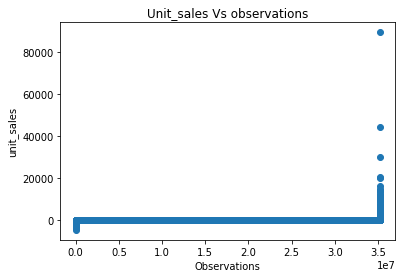

In [0]:
plt.scatter(x = range(unit_sales.shape[0]), y = np.sort(unit_sales))
plt.title('Unit_sales Vs observations')
plt.xlabel('Observations')
plt.ylabel('unit_sales')

This plot isn't super informative but does show us that quite a few outliers exist on the sales side

In [0]:
del unit_sales; gc.collect()

125

In [0]:
#Reading location_details dataset
location_details = pd.read_csv('/content/drive/My Drive/phd/location_details.csv', header = 0, dtype={'city':'category',
                                                                          'state':'category',
                                                                          'type':'category',
                                                                          'cluster':'int8'})
print(location_details.shape)

(54, 5)


The Location_details dataset has 54 rows and 5 columns as follows

**locations.csv**:
* location_id: The location of the store / warehouse (unit)
* city: The city where the unit is located
* state: The state in which the city is located
* type: The type of business unit (‘A’, ‘B’, ‘C’, ‘D’, ‘E’)
* cluster: The cluster that the unit belongs to (Provided by the
  Business Intelligence team)

In [0]:
location_details.head(5)

,location_id,city,state,type,cluster
0,location_1,Bengaluru,Karnataka,D,13
1,location_2,Bengaluru,Karnataka,D,13
2,location_3,Bengaluru,Karnataka,D,8
3,location_4,Bengaluru,Karnataka,D,9
4,location_5,Delhi,NCR,D,4


In [0]:
# checking null values 
location_details.isnull().sum()

location_id    0
city           0
state          0
type           0
cluster        0
dtype: int64

No missing values in the location_details data set

# **Type**

In [0]:
uploaded = files.upload()

Saving Type.png to Type.png


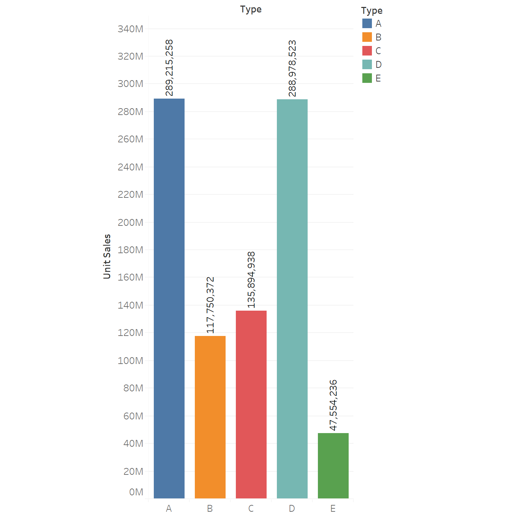

In [0]:
Image("Type.png",width=700)

Sum of unit sales for each Type ,from the above plot we can see that Type "A" is having more unit sales and Type "E" is having less unit sales . 

# **Cities**

In [0]:
location_details["city"].unique().shape[0]

22

Text(0, 0.5, 'Location id')

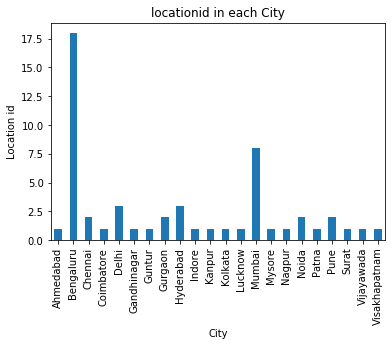

In [0]:
location_details["city"].value_counts(sort = False).plot.bar()
plt.title('locationid in each City')
plt.xlabel('City')
plt.ylabel('Location id')

The 54 locationids are located in 22 different cities. The city with the most locationids is Bengaluru and there are a number of cities that only have one store.

In [0]:
# importing modules requred for image imorting 
from google.colab import files
from IPython.display import Image
uploaded = files.upload()


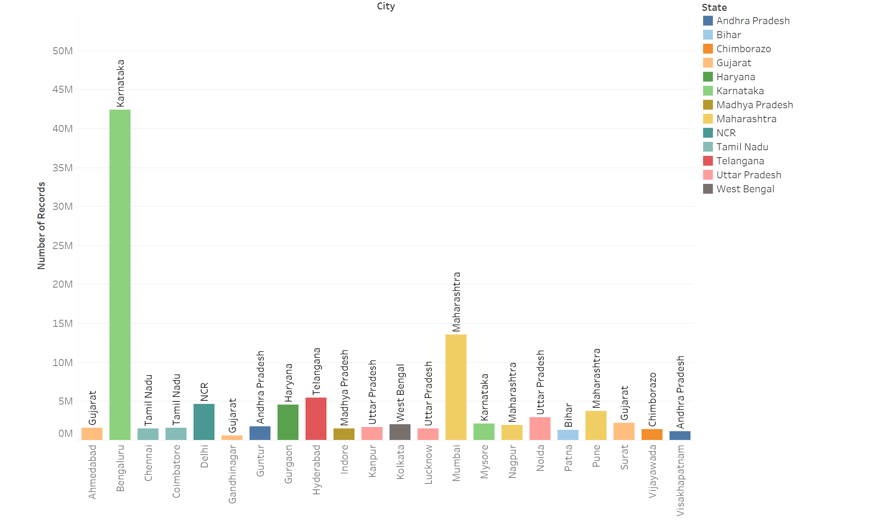

In [0]:
Image("city.png",width = 900)

Sum of Number of Records for each city ,colour refers to state. In this Karntaka state Bengaluru is having large number of records and in Gujarat state Gandhinagar & Surat cities is having small number of records

In [0]:
uploaded = files.upload()

Saving cluster2.png to cluster2.png


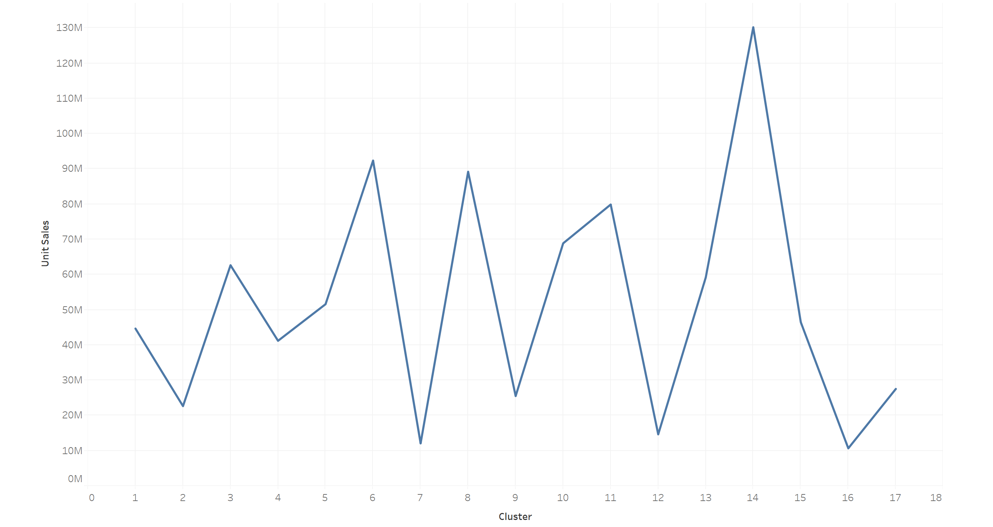

In [0]:
Image("cluster2.png",width = 900)

The Trend of Sum of unit sales for cluster,from the above plot 14 th cluster is have hight unit sales

# **Items**

In [0]:
# Reading item_details dataset
item = pd.read_csv('/content/drive/My Drive/phd/item_details.csv', dtype={'item_id':'object',
                                                                                          'category_of_item':'category',
                                                                                          'class':'category',
                                                                                          'perishable':'int8'})
print(item.shape)

(4100, 4)


The item_ details has 4100 rows and 4 columns as follows

**items.csv**
* item_id: An identifier of a product
* category_of_item: The category to which the product belongs to
* class: Another way to categorize the product (Provided by the
  Business Intelligence Team)
* perishable: Whether the item is perishable or not

Now, let's see how many category_of_item there are.

30


Text(0, 0.5, 'Count')

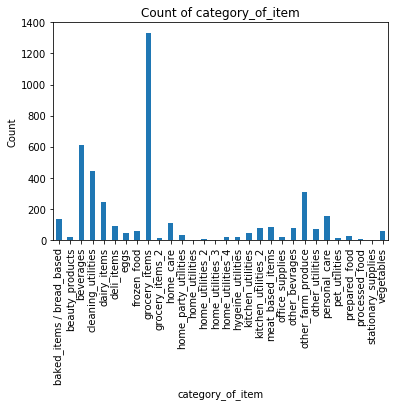

In [0]:
print(item["category_of_item"].unique().shape[0])
item["category_of_item"].value_counts(sort = False).plot.bar()
plt.title('Count of category_of_item')
plt.xlabel('category_of_item')
plt.ylabel('Count')

There are 30 differenet category_of_item. The most popular category_of_item is called "grocery_items", followed by few less popular category of items.

# **Transactions**

In [0]:
# Reading Transaction dataset
transactions = pd.read_csv('/content/drive/My Drive/phd/train_transactions.csv', dtype={'location_identifier':'category',})
                                                                                          
print(transactions.shape)

(71391, 3)


Transactions data set has 71391 rows and 3 columns as follows

**train_transactions.csv**:
* date: The day during which the number of transactions are measured
  (Only given for the duration of the ‘train.csv’ file)
* location_identifier (location_id in train.csv): The location from
  where the transactions were handled
* transactions: The number of transactions handled by the particular
  location

In [0]:
transactions.head(5)

,date,location_identifier,transactions
0,2015-01-01,location_25,770
1,2015-01-02,location_1,2111
2,2015-01-02,location_2,2358
3,2015-01-02,location_3,3487
4,2015-01-02,location_4,1922


The items data has 71391 rows and 3 columns: date,location_identifier,transactions

# ****Merging**** **data**

In [0]:
# Merging train dataset with item deatils dataset
data_item = pd.merge(data,item, left_on='item_id', right_on='item_id', how = 'left' )
print(data_item.shape)

(101688779, 8)


In [0]:
# Renaming column name
data_item.rename(columns={'locationId':'location_id'},inplace=True)
print(data_item.columns)

Index(['date', 'location_id', 'item_id', 'unit_sales', 'onpromotion',
       'category_of_item', 'class', 'perishable'],
      dtype='object')


In [0]:
# merging traing and item details dataset with location details
data_item_location = pd.merge(data_item,location_details, left_on='location_id', right_on='location_id', how = 'left' )
print(data_item_location.shape)

(101688779, 12)


In [0]:
data_item_location.head(5)

,date,location_id,item_id,unit_sales,onpromotion,category_of_item,class,perishable,city,state,type,cluster
0,2015-01-01,location_25,item_103665,7.0,NaN,baked_items / bread_based,class_2712,1,Kanpur,Uttar Pradesh,D,1
1,2015-01-01,location_25,item_105574,1.0,NaN,grocery_items,class_1045,0,Kanpur,Uttar Pradesh,D,1
2,2015-01-01,location_25,item_105575,2.0,NaN,grocery_items,class_1045,0,Kanpur,Uttar Pradesh,D,1
3,2015-01-01,location_25,item_108079,1.0,NaN,grocery_items,class_1030,0,Kanpur,Uttar Pradesh,D,1
4,2015-01-01,location_25,item_108701,1.0,NaN,deli_items,class_2644,1,Kanpur,Uttar Pradesh,D,1


In [0]:
data_item_location.isnull().sum()

date                       0
location_id                0
item_id                    0
unit_sales                 0
onpromotion         21657651
category_of_item           0
class                      0
perishable                 0
city                       0
state                      0
type                       0
cluster                    0
dtype: int64

In [0]:
data_item_location.onpromotion.replace({True: 1, False: 0}, inplace=True)
print(data_item_location.dtypes)

date                  object
location_id           object
item_id               object
unit_sales           float32
onpromotion           object
category_of_item    category
class               category
perishable              int8
city                category
state               category
type                category
cluster                 int8
dtype: object


In [0]:
# Converting to categorical data types
data_item_location['item_id'] = data_item_location['item_id'].astype('category')
data_item_location['location_id'] = data_item_location['location_id'].astype('category')
data_item_location['onpromotion'] = data_item_location['onpromotion'].astype('category')
print(data_item_location.dtypes)

date                  object
location_id         category
item_id             category
unit_sales           float32
onpromotion         category
category_of_item    category
class               category
perishable              int8
city                category
state               category
type                category
cluster                 int8
dtype: object


In [0]:
print(data_item_location.nunique())

date                  1456
location_id             53
item_id               3890
unit_sales          244090
onpromotion              2
category_of_item        30
class                  328
perishable               2
city                    22
state                   13
type                     5
cluster                 17
dtype: int64


In [0]:
print(data_item_location.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101688779 entries, 0 to 101688778
Data columns (total 12 columns):
date                object
location_id         category
item_id             category
unit_sales          float32
onpromotion         category
category_of_item    category
class               category
perishable          int8
city                category
state               category
type                category
cluster             int8
dtypes: category(8), float32(1), int8(2), object(1)
memory usage: 8.6 GB
None


In [0]:
# saving to pickel file
data_item_location.to_pickle('./merged_data.pkl')

In [0]:
# Reading merged data
data_item_location = pd.read_pickle('/content/drive/My Drive/phd/merged_data.pkl')


In [0]:
for col in data_item_location.select_dtypes(include=['object']):
    print(col)
data_item_location.loc[0, 'date']

date


'2015-01-01'

In [0]:
# Convert an object type to a datetime type
data_item_location.date = pd.to_datetime(data_item_location.date,format = "%Y-%m-%d %H:%M:%S")

In [0]:
data_item_location.dtypes

date                datetime64[ns]
location_id               category
item_id                   category
unit_sales                 float32
onpromotion               category
category_of_item          category
class                     category
perishable                    int8
city                      category
state                     category
type                      category
cluster                       int8
dtype: object

In [0]:
print(data_item_location.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101688779 entries, 0 to 101688778
Data columns (total 12 columns):
date                datetime64[ns]
location_id         category
item_id             category
unit_sales          float32
onpromotion         category
category_of_item    category
class               category
perishable          int8
city                category
state               category
type                category
cluster             int8
dtypes: category(8), datetime64[ns](1), float32(1), int8(2)
memory usage: 5.5 GB
None


In [0]:
# create new columns year, month, day of week
data_item_location['year'] = pd.DatetimeIndex(data_item_location['date']).year
data_item_location.head()
data_item_location['month'] = pd.DatetimeIndex(data_item_location['date']).month
data_item_location.head()
data_item_location['day of week'] = pd.DatetimeIndex(data_item_location['date']).dayofweek
data_item_location.head()

,date,location_id,item_id,unit_sales,onpromotion,category_of_item,class,perishable,city,state,type,cluster,year,month,day of week
0,2015-01-01,location_25,item_103665,7.0,NaN,baked_items / bread_based,class_2712,1,Kanpur,Uttar Pradesh,D,1,2015,1,3
1,2015-01-01,location_25,item_105574,1.0,NaN,grocery_items,class_1045,0,Kanpur,Uttar Pradesh,D,1,2015,1,3
2,2015-01-01,location_25,item_105575,2.0,NaN,grocery_items,class_1045,0,Kanpur,Uttar Pradesh,D,1,2015,1,3
3,2015-01-01,location_25,item_108079,1.0,NaN,grocery_items,class_1030,0,Kanpur,Uttar Pradesh,D,1,2015,1,3
4,2015-01-01,location_25,item_108701,1.0,NaN,deli_items,class_2644,1,Kanpur,Uttar Pradesh,D,1,2015,1,3


# **Subsetting** **Merged** **data** **by** **Years**

In [0]:

year_subset1=data_item_location[data_item_location.year == 2015]

In [0]:

year_subset2=data_item_location[data_item_location.year == 2016]

In [0]:

year_subset3=data_item_location[data_item_location.year == 2017]

In [0]:

year_subset4=data_item_location[data_item_location.year == 2018]

In [0]:
print(year_subset1.shape)
print(year_subset2.shape)
print(year_subset3.shape)
print(year_subset4.shape)


(16322662, 14)
(22271602, 14)
(27864644, 14)
(35229871, 14)


In [0]:
# Dropping columns
year_subset4.drop(['date','location_id','item_id','class','city','state','year','month'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
year_subset4.head(5)

,unit_sales,onpromotion,category_of_item,perishable,type,cluster
66458908,12.0,False,grocery_items,0,D,1
66458909,9.0,False,grocery_items,0,D,1
66458910,3.0,False,grocery_items,0,D,1
66458911,3.0,False,grocery_items,0,D,1
66458912,2.0,True,deli_items,1,D,1


In [0]:
year_subset4.shape

(35229871, 6)

# **Binning** **Category** **of** **item** **column**

In [0]:
year_subset4.replace(['kitchen_utilities_2','kitchen_utilities','processed_food','grocery_items_2',
                                   'other_utilities','home_party_utilities','hygeine_utilities','home_utilities_4',
                                   'pet_utilities','home_utilities_2','beauty_products',
                                   'office_supplies','home_utilities','home_utilities_3','stationary_supplies'],'other_items', inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [0]:
year_subset4.replace(['deli_items','frozen_food'],'Frozen_food_&_deli_items', inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [0]:
year_subset4.replace(['personal_care','home_care'],'personal_&_home_care', inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [0]:
year_subset4.replace(['baked_items / bread_based','eggs'],'baked_&_egg', inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [0]:
year_subset4.replace(['vegetables','prepared_food'],'pre_food_&_Vegetables', inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [0]:
year_subset4.replace(['other_bevrages','meat_based_items'],'meats_&_Bevrages' , inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [0]:
print(year_subset4.nunique())

unit_sales          138084
onpromotion              2
category_of_item        11
perishable               2
type                     5
cluster                 17
dtype: int64


In [0]:
#saving data to pickle file
year_subset4.to_pickle('./merged_data1.pkl')

In [0]:
year_subset5 = pd.read_pickle('/content/drive/My Drive/phd/merged_data1.pkl')

# **Dummification**

In [0]:
dummies = pd.get_dummies(year_subset5['onpromotion'], prefix = 'op')
year_subset5 = pd.concat([year_subset5, dummies], axis=1)

In [0]:
year_subset5.head(5)

,unit_sales,onpromotion,category_of_item,perishable,type,cluster,op_False,op_True
66458908,12.0,False,grocery_items,0,D,1,1,0
66458909,9.0,False,grocery_items,0,D,1,1,0
66458910,3.0,False,grocery_items,0,D,1,1,0
66458911,3.0,False,grocery_items,0,D,1,1,0
66458912,2.0,True,Frozen_food_&_deli_items,1,D,1,0,1


In [0]:
dummies = pd.get_dummies(year_subset5['perishable'], prefix = 'p')
year_subset5 = pd.concat([year_subset5, dummies], axis=1)

In [0]:
year_subset5.head(5)

,unit_sales,onpromotion,category_of_item,perishable,type,cluster,op_False,op_True,p_0,p_1
66458908,12.0,False,grocery_items,0,D,1,1,0,1,0
66458909,9.0,False,grocery_items,0,D,1,1,0,1,0
66458910,3.0,False,grocery_items,0,D,1,1,0,1,0
66458911,3.0,False,grocery_items,0,D,1,1,0,1,0
66458912,2.0,True,Frozen_food_&_deli_items,1,D,1,0,1,0,1


In [0]:
dummies = pd.get_dummies(year_subset5['type'], prefix = 't')
year_subset5 = pd.concat([year_subset5, dummies], axis=1)

In [0]:
year_subset5.head(5)

,unit_sales,onpromotion,category_of_item,perishable,type,cluster,op_False,op_True,p_0,p_1,t_A,t_B,t_C,t_D,t_E
66458908,12.0,False,grocery_items,0,D,1,1,0,1,0,0,0,0,1,0
66458909,9.0,False,grocery_items,0,D,1,1,0,1,0,0,0,0,1,0
66458910,3.0,False,grocery_items,0,D,1,1,0,1,0,0,0,0,1,0
66458911,3.0,False,grocery_items,0,D,1,1,0,1,0,0,0,0,1,0
66458912,2.0,True,Frozen_food_&_deli_items,1,D,1,0,1,0,1,0,0,0,1,0


In [0]:
dummies = pd.get_dummies(year_subset5['cluster'], prefix = 'c')
year_subset5 = pd.concat([year_subset5, dummies], axis=1)

In [0]:
year_subset5.shape
     


(35229871, 32)

In [0]:
 year_subset5.head(5)

,unit_sales,onpromotion,category_of_item,perishable,type,cluster,op_False,op_True,p_0,p_1,t_A,t_B,t_C,t_D,t_E,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17
66458908,12.0,False,grocery_items,0,D,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66458909,9.0,False,grocery_items,0,D,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66458910,3.0,False,grocery_items,0,D,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66458911,3.0,False,grocery_items,0,D,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66458912,2.0,True,Frozen_food_&_deli_items,1,D,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
dummies = pd.get_dummies(year_subset5['category_of_item'], prefix = 'ctg')
year_subset5 = pd.concat([year_subset5, dummies], axis=1)

In [0]:
year_subset5.shape

(35229871, 43)

In [0]:
year_subset5.drop(['onpromotion','category_of_item','perishable','type','cluster'], axis=1, inplace=True)

In [0]:
year_subset5.shape

(35229871, 38)

In [0]:
#saving data to pickle file
year_subset5.to_pickle('./merged_data2.pkl')

In [0]:
year_subset6 = pd.read_pickle('/content/drive/My Drive/phd/merged_data2.pkl')

In [0]:
year_subset6 = year_subset6[~(year_subset6['unit_sales'] < 0)]

In [0]:
# splitting  data into X and y
y=year_subset6["unit_sales"]
X= year_subset6.drop('unit_sales', axis=1)

In [0]:
year_subset6.head(5)

,unit_sales,op_False,op_True,p_0,p_1,t_A,t_B,t_C,t_D,t_E,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,ctg_Frozen_food_&_deli_items,ctg_baked_&_egg,ctg_beverages,ctg_cleaning_utilities,ctg_dairy_items,ctg_grocery_items,ctg_meats_&_Bevrages,ctg_other_farm_produce,ctg_other_items,ctg_personal_&_home_care,ctg_pre_food_&_Vegetables
66458908,12.0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
66458909,9.0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
66458910,3.0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
66458911,3.0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
66458912,2.0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [0]:
#Principal Component Analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principal_components = pca.fit_transform(X)
new_X = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2','PC3','PC4','PC5'])

In [0]:
 from sklearn.model_selection import train_test_split

In [0]:
#splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.20)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28183896, 5)
(7045975, 5)
(28183896,)
(7045975,)


# **Linear** **Regression**

In [0]:
# importing model
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
model = linear_model.fit(X_train,y_train)

In [0]:
pred = model.predict(X_test)

In [0]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, pred)

7.310964760998592

# **Test** **Data**

In [0]:
# Reading Test data
test = pd.read_csv('/content/drive/My Drive/phd/test.csv', header=0,dtype={'date':'object',
                                                                                  'locationId':'category',
                                                                                  'item_id':'object',
                                                                                  'onpromotion':'object'})

In [0]:
print(test.shape)

print(test.isnull().sum())

(1482295, 5)
id             0
date           0
locationId     0
item_id        0
onpromotion    0
dtype: int64


In [0]:
print(test.nunique())

id             1482295
date                15
locationId          53
item_id           3828
onpromotion          2
dtype: int64


In [0]:
test.head(5)

,id,date,locationId,item_id,onpromotion
0,0,2019-01-01,location_25,item_99197,False
1,1,2019-01-01,location_25,item_103665,False
2,2,2019-01-01,location_25,item_105574,False
3,3,2019-01-01,location_25,item_105857,False
4,4,2019-01-01,location_25,item_106716,False


In [0]:
test1=test.drop(['id'], axis=1)
test1.head()

,date,locationId,item_id,onpromotion
0,2019-01-01,location_25,item_99197,False
1,2019-01-01,location_25,item_103665,False
2,2019-01-01,location_25,item_105574,False
3,2019-01-01,location_25,item_105857,False
4,2019-01-01,location_25,item_106716,False


# **Merging** **Test** **data**

In [0]:
test_item = pd.merge(test,item, left_on='item_id', right_on='item_id', how = 'left' )
print(test_item.shape)

(1482295, 8)


In [0]:
test_item.rename(columns={'locationId':'location_id'},inplace=True)

In [0]:
test_item_location = pd.merge(test_item,location_details, left_on='location_id', right_on='location_id', how = 'left' )
print(test_item_location.shape)

(1482295, 12)


In [0]:
test_item_location.drop(['date','location_id','item_id','class','city','state'], axis=1, inplace=True)
print(test_item_location.head())

  onpromotion           category_of_item  perishable type  cluster
0       False              grocery_items           0    D        1
1       False  baked_items / bread_based           1    D        1
2       False              grocery_items           0    D        1
3       False              grocery_items           0    D        1
4       False              grocery_items           0    D        1


# **Binning**

In [0]:
test_item_location.replace(['kitchen_utilities_2','kitchen_utilities','processed_food','grocery_items_2',
                                   'other_utilities','home_party_utilities','hygeine_utilities','home_utilities_4',
                                   'pet_utilities','home_utilities_2','beauty_products',
                                   'office_supplies','home_utilities','home_utilities_3','stationary_supplies'],'other_items', inplace=True)

In [0]:
test_item_location.replace(['deli_items','frozen_food'],'Frozen_food_&_deli_items', inplace=True)

In [0]:
test_item_location.replace(['personal_care','home_care'],'personal_&_home_care', inplace=True)

In [0]:
test_item_location.replace(['baked_items / bread_based','eggs'],'baked_&_egg', inplace=True)

In [0]:
test_item_location.replace(['vegetables','prepared_food'],'pre_food_&_Vegetables', inplace=True)

In [0]:
test_item_location.replace(['other_bevrages','meat_based_items'],'meats_&_Bevrages' , inplace=True)

In [0]:
print(test_item_location.nunique())

onpromotion          2
category_of_item    11
perishable           2
type                 5
cluster             17
dtype: int64


In [0]:
#saving as pickle file
test_item_location.to_pickle('./merged_test1.pkl')

In [0]:
test_item_location1 = pd.read_pickle('/content/drive/My Drive/phd/merged_test1.pkl')

In [0]:
test_item_location1.head()

,onpromotion,category_of_item,perishable,type,cluster
0,False,grocery_items,0,D,1
1,False,baked_&_egg,1,D,1
2,False,grocery_items,0,D,1
3,False,grocery_items,0,D,1
4,False,grocery_items,0,D,1


# **Dummification**

In [0]:
dummies = pd.get_dummies(test_item_location1['onpromotion'], prefix = 'op')
test_item_location1 = pd.concat([test_item_location1, dummies], axis=1)

In [0]:
dummies = pd.get_dummies(test_item_location1['perishable'], prefix = 'p')
test_item_location1 = pd.concat([test_item_location1, dummies], axis=1)

In [0]:
dummies = pd.get_dummies(test_item_location1['type'], prefix = 't')
test_item_location1 = pd.concat([test_item_location1, dummies], axis=1)

In [0]:
dummies = pd.get_dummies(test_item_location1['cluster'], prefix = 'c')
test_item_location1 = pd.concat([test_item_location1, dummies], axis=1)

In [0]:
dummies = pd.get_dummies(test_item_location1['category_of_item'], prefix = 'ctg')
test_item_location1 = pd.concat([test_item_location1, dummies], axis=1)

In [0]:
test_item_location1.shape

(1482295, 42)

In [0]:
test_item_location1.drop(['onpromotion','category_of_item','perishable','type','cluster'], axis=1, inplace=True)

In [0]:
test_item_location1.shape

(1482295, 37)

In [0]:
test_item_location1.to_pickle('./merged_test2.pkl')

In [0]:
test_item_location2 = pd.read_pickle('/content/drive/My Drive/phd/merged_test2.pkl')

In [0]:
#Principal Component Analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principal_components = pca.fit_transform(test_item_location2)
new_test = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2','PC3','PC4','PC5'])

In [0]:
y_predict = model.predict(new_test)

In [0]:
y_predict.shape

(1482295,)

In [0]:
new_test['unit_sales']= y_predict

In [0]:
new_test['id']= test['id']

In [0]:
new_test.head()

,PC1,PC2,PC3,PC4,PC5,unit_sales,id
0,-0.469653,0.869094,-0.069266,-0.044822,-0.503257,5.654727,0
1,1.218543,0.608012,0.029547,-0.049145,-0.121955,9.688766,1
2,-0.469653,0.869094,-0.069266,-0.044822,-0.503257,5.654727,2
3,-0.469653,0.869094,-0.069266,-0.044822,-0.503257,5.654727,3
4,-0.469653,0.869094,-0.069266,-0.044822,-0.503257,5.654727,4


In [0]:
min(new_test['unit_sales'])

4.403211697602803

In [0]:
new_test[['id','unit_sales']].to_csv('sample_submission2.csv.gz', index=False, float_format='%.3f', compression='gzip')

# **Label** **Encoding** **for** **training** **data**

In [0]:
year_subset4 = year_subset4.drop(['date','category_of_item', 'class','perishable', 'city', 'state', 'type',
       'cluster','year','month'], axis = 1)

In [0]:
categorical_list =['location_id', 'item_id', 'onpromotion']

In [0]:
for i in year_subset4[categorical_list]:
    year_subset4[i] = year_subset4[i].astype("category")

In [0]:
year_subset4.dtypes

location_id    category
item_id        category
unit_sales      float32
onpromotion    category
day of week       int64
dtype: object

In [0]:
# importing label encoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for i in categorical_list:
    le.fit(year_subset4[i])
    year_subset4[i] = le.transform(year_subset4[i])

In [0]:
year_subset4.head()

,location_id,item_id,unit_sales,onpromotion,day of week
66458908,17,120,12.0,0,0
66458909,17,121,9.0,0,0
66458910,17,133,3.0,0,0
66458911,17,194,3.0,0,0
66458912,17,197,2.0,1,0


In [0]:
year_subset4.to_pickle('./merged_rf_data.pkl')

In [0]:
year_subset4 = pd.read_pickle('/content/drive/My Drive/phd/merged_rf_data.pkl')

In [0]:
year_subset4 = year_subset4[~(year_subset4['unit_sales'] < 0)]

In [0]:
from sklearn.model_selection import train_test_split

y=year_subset4["unit_sales"]
X= year_subset4.drop('unit_sales', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=826)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(28182100, 4)
(7045525, 4)
(28182100,)
(7045525,)


# **Random** **Forest**

In [0]:
# importing model
from sklearn.ensemble import RandomForestRegressor
%time
RFG = RandomForestRegressor(n_estimators=10, min_samples_leaf=3)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


In [0]:
gc.collect()

104

In [0]:
# Fitting the model 
RFG.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  3.7min remaining:   55.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=1, warm_start=False)

In [0]:
train_pred =RFG.predict(X_train)
val_pred = RFG.predict(X_val)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   56.9s remaining:  3.8min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  1.0min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   14.7s remaining:   58.7s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   15.7s finished


In [0]:
# print(train mean_absolute_error :\n)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_train,train_pred))

3.5285948357119494


In [0]:
# print(validation mean_absolute_error :\n)
print(mean_absolute_error(y_val,val_pred))

3.6953084378993912


In [0]:
def mape(y_true,y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return round (np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 3)

print(mape(y_val,val_pred))

82.681


In [0]:
print(mape(y_train,train_pred))

78.601


# **Label** **Encoding** **for** **test** **data**

In [0]:
test_item_location.to_pickle('./merged_rf_test.pkl')

In [0]:
test_item_location1 = pd.read_pickle('/content/drive/My Drive/phd/merged_rf_test.pkl')

In [0]:
test_item_location1.columns

Index(['date', 'location_id', 'item_id', 'onpromotion', 'category_of_item',
       'class', 'perishable', 'city', 'state', 'type', 'cluster'],
      dtype='object')

In [0]:
# Convert an object type to a datetime 
test_item_location1.date = pd.to_datetime(test_item_location1.date,format = "%Y-%m-%d %H:%M:%S")

In [0]:
test_item_location1['day of week'] = pd.DatetimeIndex(test_item_location1['date']).dayofweek
test_item_location1.head()


,date,location_id,item_id,onpromotion,category_of_item,class,perishable,city,state,type,cluster,day of week
0,2019-01-01,location_25,item_99197,False,grocery_items,class_1067,0,Kanpur,Uttar Pradesh,D,1,1
1,2019-01-01,location_25,item_103665,False,baked_items / bread_based,class_2712,1,Kanpur,Uttar Pradesh,D,1,1
2,2019-01-01,location_25,item_105574,False,grocery_items,class_1045,0,Kanpur,Uttar Pradesh,D,1,1
3,2019-01-01,location_25,item_105857,False,grocery_items,class_1092,0,Kanpur,Uttar Pradesh,D,1,1
4,2019-01-01,location_25,item_106716,False,grocery_items,class_1032,0,Kanpur,Uttar Pradesh,D,1,1


In [0]:
test_item_location1 = test_item_location1.drop(['date','category_of_item', 'class','perishable', 'city', 'state', 'type',
       'cluster'], axis = 1)

In [0]:
categorical_list =['location_id', 'item_id', 'onpromotion']

In [0]:
for i in test_item_location1[categorical_list]:
    test_item_location1[i] = test_item_location1[i].astype("category")

In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for i in categorical_list:
    le.fit(test_item_location1[i])
    test_item_location1[i] = le.transform(test_item_location1[i])

In [0]:
test_item_location1.head()

,location_id,item_id,onpromotion,day of week
0,17,3818,0,1
1,17,45,0,1
2,17,119,0,1
3,17,132,0,1
4,17,143,0,1


In [0]:
y_predict = RFG.predict(test_item_location1)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.9s remaining:    3.7s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.0s finished


In [0]:
sample_submission = pd.read_csv('/content/drive/My Drive/phd/sample_submission.csv', header = 0)
print(sample_submission.shape)

(1482295, 2)


In [0]:
sample_submission['unit_sales']= y_predict

In [0]:
sample_submission.head()

,id,unit_sales
0,0,1.246272
1,1,2.449158
2,2,1.208298
3,3,1.448163
4,4,2.508662


In [0]:
sample_submission[['id','unit_sales']].to_csv('sample_submission6.csv.gz', index=False, float_format='%.3f', compression='gzip')

# **Log** **MA** and **days** **of** **week** **means**

In [0]:
year_subset4.drop(['class','city','state','type','cluster','perishable'
                                            ,'year','month','category_of_item'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
year_subset4.dtypes

date           datetime64[ns]
location_id          category
item_id              category
unit_sales            float32
onpromotion          category
dtype: object

In [0]:
year_subset4.head(5)

,date,location_id,item_id,unit_sales,onpromotion
66458908,2018-01-01,location_25,item_105574,12.0,False
66458909,2018-01-01,location_25,item_105575,9.0,False
66458910,2018-01-01,location_25,item_105857,3.0,False
66458911,2018-01-01,location_25,item_108634,3.0,False
66458912,2018-01-01,location_25,item_108701,2.0,True


In [0]:
year_subset4.location_id = year_subset4.location_id.map(lambda x: int(x.split('_')[1]))
year_subset4.item_id = year_subset4.item_id.map(lambda x: int(x.split('_')[1]))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(year_subset4, test_size=0.20)
print(X_train.shape)
print(X_test.shape)

(28183896, 5)
(7045975, 5)


In [0]:
X_train['unit_sales'] =  X_train['unit_sales'].apply(pd.np.log1p) #logarithm conversion
X_train['dow'] = X_train['date'].dt.dayofweek

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
X_train.head(5)

,date,location_id,item_id,unit_sales,onpromotion,dow
94928038,2018-10-25,35,115267,0.526589,True,3
101290814,2018-12-28,19,738219,1.248441,False,4
79127642,2018-05-14,11,1114914,1.162283,False,0
95717652,2018-11-02,39,1231869,0.526589,False,4
88533371,2018-08-20,8,1489899,1.358505,False,0


In [0]:
ma_dw = X_train[['item_id','location_id','dow','unit_sales']].groupby(
        ['item_id','location_id','dow'])['unit_sales'].mean().to_frame('madw').reset_index()
ma_wk = ma_dw[['item_id','location_id','madw']].groupby(
        ['location_id', 'item_id'])['madw'].mean().to_frame('mawk').reset_index()

X_train.drop('dow',1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
ma_is = X_train[['item_id','location_id','unit_sales']].groupby(
        ['item_id','location_id'])['unit_sales'].mean().to_frame('mais')

In [0]:
lastdate = X_train.iloc[X_train.shape[0]-1].date

In [0]:
from datetime import timedelta

In [0]:
for i in [112,56,28,14,7,3,1]:
    tmp = X_train[X_train.date>lastdate-timedelta(int(i))]
    tmpg = tmp.groupby(['item_id','location_id'])['unit_sales'].mean().to_frame('mais'+str(i))
    ma_is = ma_is.join(tmpg, how='left')

del tmp,tmpg

In [0]:
ma_is['mais']=ma_is.median(axis=1)
ma_is.reset_index(inplace=True)
ma_is.drop(list(ma_is.columns.values)[3:],1,inplace=True)

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [0]:
X_test['dow'] = X_test['date'].dt.dayofweek

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
X_test = pd.merge(X_test, ma_is, how='left', on=['item_id','location_id'])
X_test = pd.merge(X_test, ma_wk, how='left', on=['item_id','location_id'])
X_test = pd.merge(X_test, ma_dw, how='left', on=['item_id','location_id','dow'])

In [0]:
X_test['pre_sales'] = X_test.mais 
pos_idx = X_test['mawk'] > 0
test_pos = X_test.loc[pos_idx]
X_test.loc[pos_idx, 'pre_sales'] = test_pos['mais'] * test_pos['madw'] / test_pos['mawk']
X_test.loc[:, "pre_sales"].fillna(0, inplace=True)
X_test['pre_sales'] = X_test['pre_sales'].apply(pd.np.expm1) # restoring unit values 

In [0]:
X_test.head()

,date,location_id,item_id,unit_sales,onpromotion,dow,mais,mawk,madw,pre_sales
0,2018-05-20,34,1642400,10.064,False,6,2.198243,2.382006,2.203104,6.638052
1,2018-08-01,12,1076065,4.000,False,2,1.348436,1.434742,1.471389,2.986359
2,2018-03-28,7,1457256,1.000,False,2,1.081057,1.107888,1.136648,2.031692
3,2018-09-06,49,112830,11.000,False,3,2.336193,2.347935,2.190605,7.843209
4,2018-06-19,20,1937350,2.000,False,1,0.935514,0.907839,1.063941,1.993297


In [0]:
#50% more for promotion items
X_test.loc[X_test['onpromotion'] == True , 'pre_sales'] *= 1.5

In [0]:
X_test.head()

,date,location_id,item_id,unit_sales,onpromotion,dow,mais,mawk,madw,pre_sales
0,2018-05-20,34,1642400,10.064,False,6,2.198243,2.382006,2.203104,6.638052
1,2018-08-01,12,1076065,4.000,False,2,1.348436,1.434742,1.471389,2.986359
2,2018-03-28,7,1457256,1.000,False,2,1.081057,1.107888,1.136648,2.031692
3,2018-09-06,49,112830,11.000,False,3,2.336193,2.347935,2.190605,7.843209
4,2018-06-19,20,1937350,2.000,False,1,0.935514,0.907839,1.063941,1.993297


In [0]:
y_pred = X_test['pre_sales']
y_true = X_test['unit_sales']

In [0]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_true, y_pred)

3.7242703

In [0]:
test = pd.read_csv('/content/drive/My Drive/phd/test.csv', header=0,dtype={'date':'object',
                                                                                  'locationId':'category',
                                                                                  'item_id':'object',
                                                                                  'onpromotion':'object'})

In [0]:
test.rename(columns={'locationId':'location_id'},inplace=True)

test.location_id = test.location_id.map(lambda x: int(x.split('_')[1]))
test.item_id = test.item_id.map(lambda x: int(x.split('_')[1]))

In [0]:
test.head()

,id,date,location_id,item_id,onpromotion
0,0,2019-01-01,25,99197,False
1,1,2019-01-01,25,103665,False
2,2,2019-01-01,25,105574,False
3,3,2019-01-01,25,105857,False
4,4,2019-01-01,25,106716,False


In [0]:
test['item_id'] = test['item_id'].astype('int32')
test['location_id'] = test['location_id'].astype('int8')

In [0]:
test.date = pd.to_datetime(test.date,format = "%Y-%m-%d")
test['dow'] = test['date'].dt.dayofweek

In [0]:
#test['dow'] = test['date'].dt.dayofweek
test = pd.merge(test, ma_is, how='left', on=['item_id','location_id'])
test = pd.merge(test, ma_wk, how='left', on=['item_id','location_id'])
test = pd.merge(test, ma_dw, how='left', on=['item_id','location_id','dow'])

In [0]:
test['unit_sales'] = test.mais 
pos_idx = test['mawk'] > 0
test_pos = test.loc[pos_idx]
test.loc[pos_idx, 'unit_sales'] = test_pos['mais'] * test_pos['madw'] / test_pos['mawk']
test.loc[:, "unit_sales"].fillna(0, inplace=True)
test['unit_sales'] = test['unit_sales'].apply(pd.np.expm1) # restoring unit values 

In [0]:
#50% more for promotion items
test.loc[test['onpromotion'] == True, 'unit_sales'] *= 1.5

In [0]:
test[['id','unit_sales']].to_csv('ma8dwof.csv.gz', index=False, float_format='%.3f', compression='gzip')

In [0]:
test.shape

(1482295, 10)

In [0]:
sample_submission = pd.read_csv('/content/drive/My Drive/phd/sample_submission1.csv', header = 0)
print(sample_submission.shape)

(1482295, 2)


In [0]:
test_item_location['unit_sales'] = sample_submission['unit_sales']

In [0]:
test_item_location.head()

,id,date,location_id,item_id,onpromotion,category_of_item,class,perishable,city,state,type,cluster,unit_sales
0,0,2019-01-01,location_25,item_99197,False,grocery_items,class_1067,0,Kanpur,Uttar Pradesh,D,1,1.429
1,1,2019-01-01,location_25,item_103665,False,baked_items / bread_based,class_2712,1,Kanpur,Uttar Pradesh,D,1,2.003
2,2,2019-01-01,location_25,item_105574,False,grocery_items,class_1045,0,Kanpur,Uttar Pradesh,D,1,3.574
3,3,2019-01-01,location_25,item_105857,False,grocery_items,class_1092,0,Kanpur,Uttar Pradesh,D,1,3.144
4,4,2019-01-01,location_25,item_106716,False,grocery_items,class_1032,0,Kanpur,Uttar Pradesh,D,1,2.531


In [0]:
test_item_location['unit_sales'].shape

(1482295,)

In [0]:
test_item_location.to_csv('./Finaltest_pred.csv')

In [ ]:
#import module for importing images
from IPython.display import Image

# Conclusion

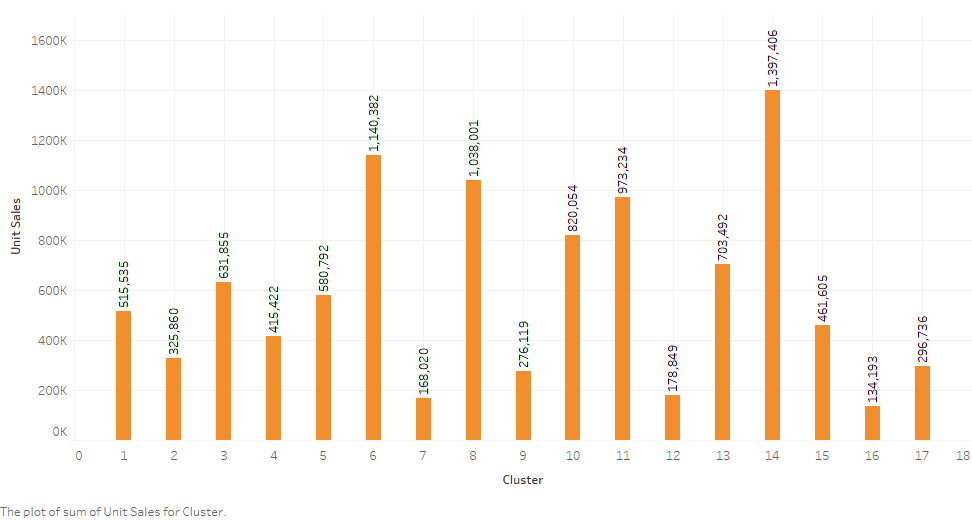

In [4]:
Image(filename= 'Picture1.png')
Image('Picture1.png',width = 800)

According to my prediction Business units belonging to 14th cluster havimg highest amount of
sales for the first 15 days of 2019.

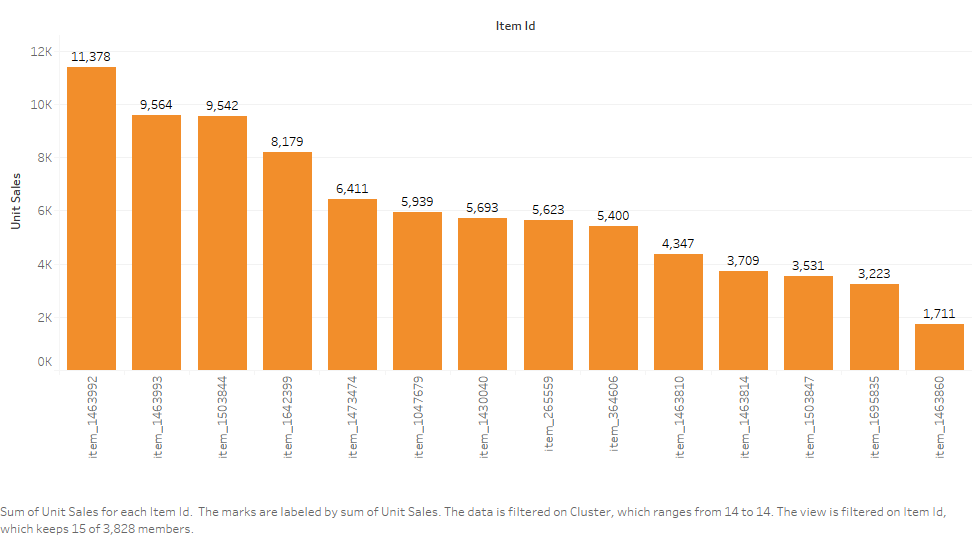

In [5]:
Image(filename= 'Picture2.png')
Image('Picture2.png',width = 800)

These are top 10 selling item_ids in 14th cluster

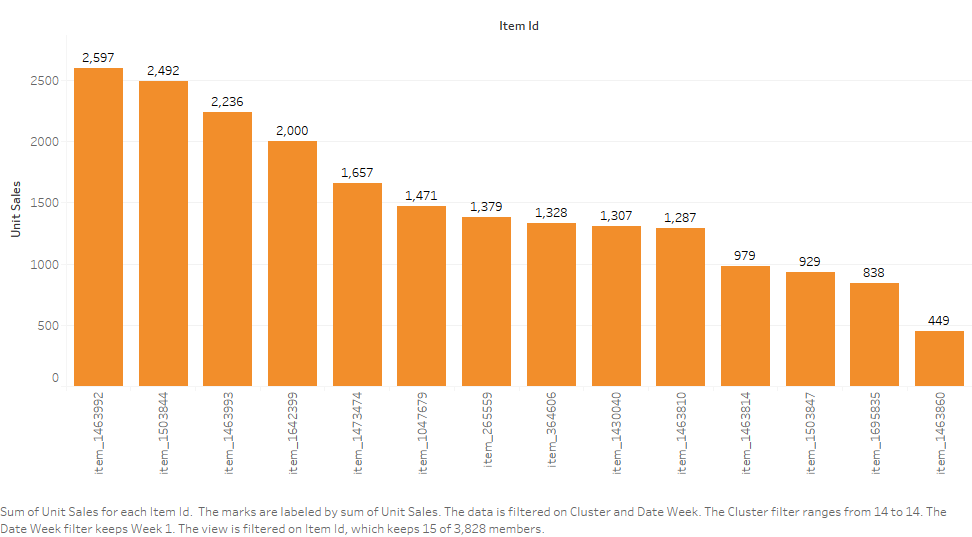

In [6]:
Image(filename= 'Picture3.png')
Image('Picture3.png',width = 800)

The rate of purchase of week1 for these item_ids in 14th cluster.

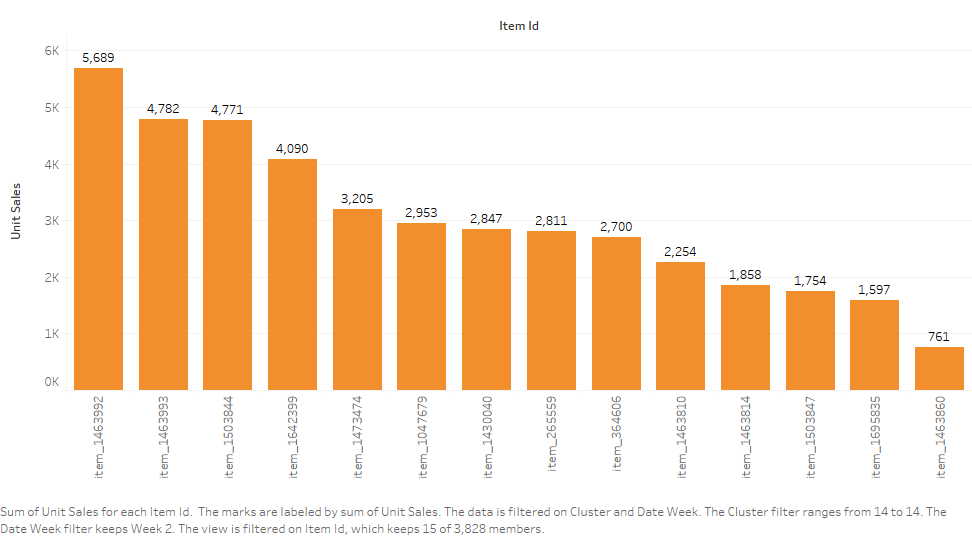

In [7]:
Image(filename= 'Picture4.png')
Image('Picture4.png',width = 800)

The rate of purchase of week2 for these item_ids in 14th cluster.

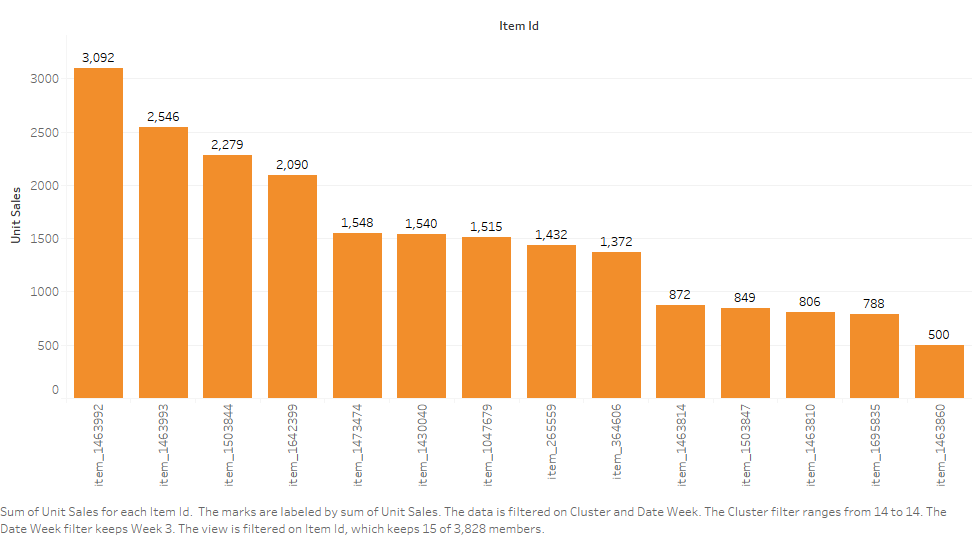

In [8]:
Image(filename= 'Picture5.png')
Image('Picture5.png',width = 800)

The rate of purchase of week3 for these item_ids in 14th cluster.

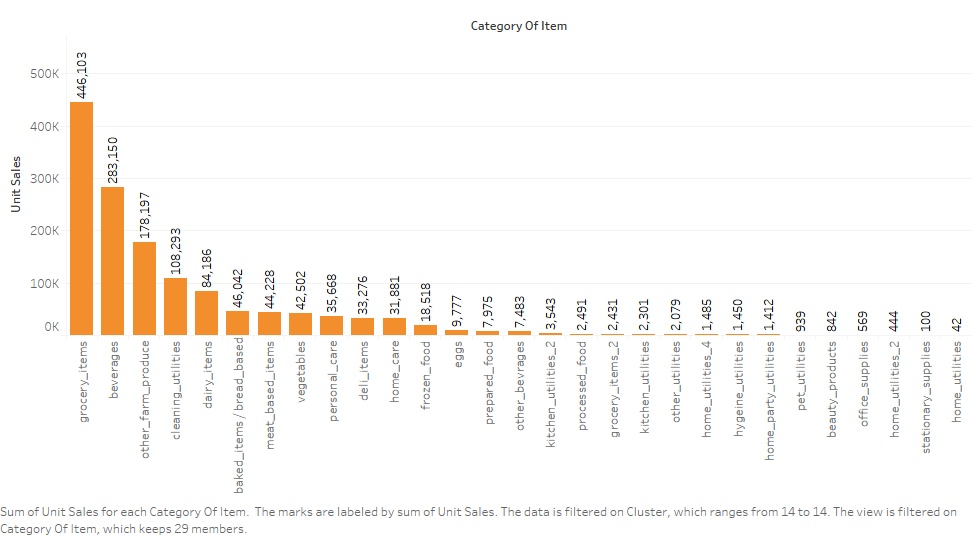

In [9]:
Image(filename= 'Picture6.png')
Image('Picture6.png',width = 800)

These are top 10 selling category of items in 14th cluster

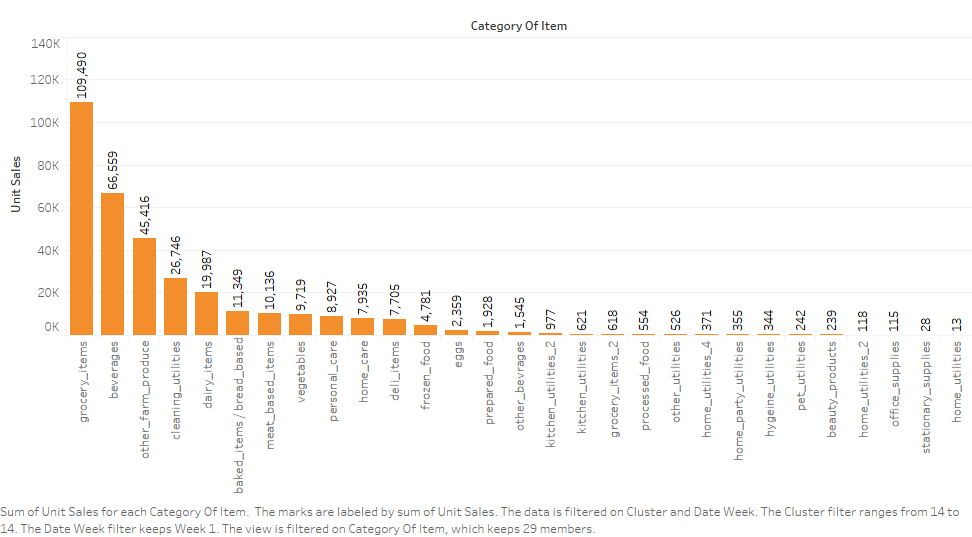

In [10]:
Image(filename= 'Picture7.png')
Image('Picture7.png',width = 800)

The rate of purchase of week1 for these category of items in 14th cluster.

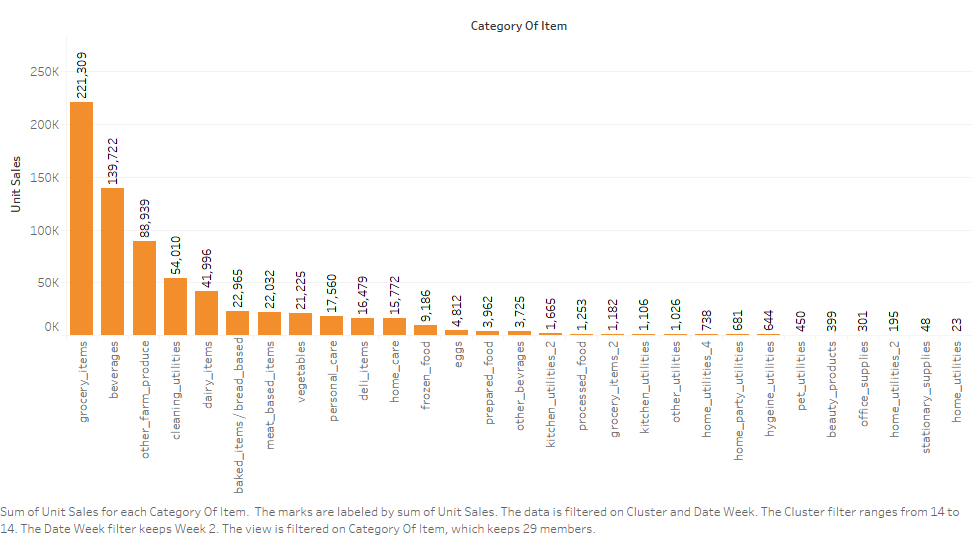

In [11]:
Image(filename= 'Picture8.png')
Image('Picture8.png',width = 800)

The rate of purchase of week 2 for these category of items in 14th cluster.

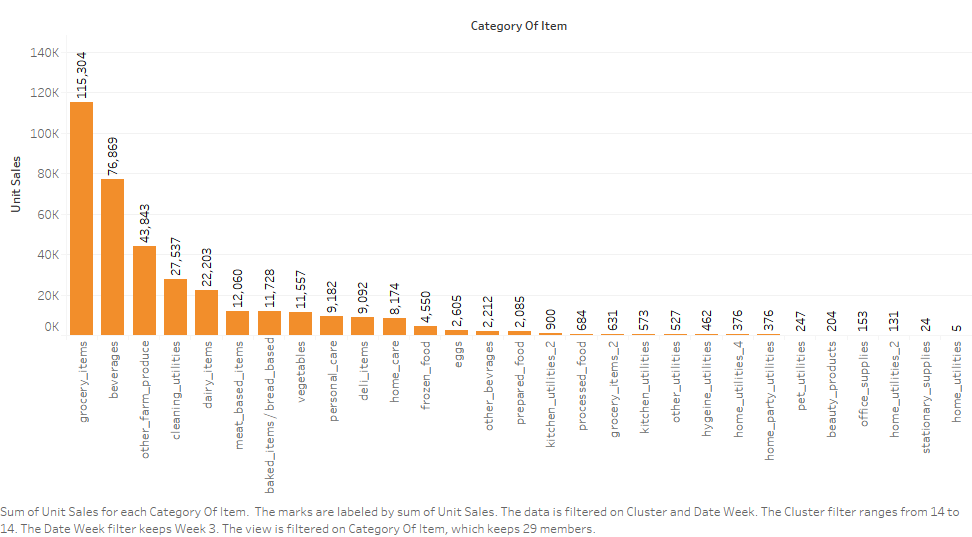

In [14]:
Image(filename= 'Picture9.png')
Image('Picture9.png',width = 800)

The rate of purchase of week 3 for these category of items in 14th cluster.